## OpenAQ API

- From the OpenAQ API, download a list of reference grade location_ids using the 'us' country code

import requests
import json

# get reference grade sensors in the United States
url = "https://api.openaq.org/v2/locations?limit=4000&page=1&offset=0&sort=desc&country=US&order_by=lastUpdated&sensor_type=reference%20grade&dump_raw=false"

headers = {
    'accept': 'application/json'
}

api_data = requests.get(url, headers=headers).json()

# get all location ids
location_ids = []
for i in api_data["results"]:
    if i['isMobile'] == False:
        location_ids.append(i["id"])

## Downloading the OpenAQ data from AWS

import boto3
from botocore import UNSIGNED
from botocore.config import Config

import pandas as pd
import csv
import gzip
import os

import concurrent.futures
from tqdm import tqdm

s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

#----- Functions -----
def download_and_process_files(key):
    # download object from S3
    # print(f'Downloading {key}')
    obj = s3.get_object(Bucket=bucket_name, Key=key)

    # unzip and store in dataframe
    try:
        with gzip.open(obj['Body'], 'rb') as f:
            df = pd.read_csv(f)
        return df
    except Exception as e:
        print(f'Error in Gzip process: {e}')
# --------------------

# OpenAQ bucket name and base path
bucket_name = 'openaq-data-archive'
base_s3_path = 'records/csv.gz'

# location of CSV with location IDs
location_ids_csv = './location_ids.csv'

# parquet output path
parquet_path = 'G:/_data'

# number of workers used to download from S3 in parallel
num_workers = 200

location_ids = []

with open(location_ids_csv, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        location_ids.append(row[0])

for i in range(len(location_ids)):

    location_id = location_ids[i]

    # check for existing local file
    if os.path.exists(f'{parquet_path}/{location_id}.parquet'):
        print(f'Location {location_id} [{i + 1}/{len(location_ids)}] : Already downloaded')
        continue

    # set S3 path
    s3_path = f'{base_s3_path}/locationid={location_id}'

    # init pagination variables
    continuation_token = None
    s3_files = []

    # paginate through the objects
    while True:
        if continuation_token:
            response = s3.list_objects_v2(Bucket=bucket_name, Prefix=s3_path, ContinuationToken=continuation_token)
        else:
            response = s3.list_objects_v2(Bucket=bucket_name, Prefix=s3_path)

        s3_files.extend([obj['Key'] for obj in response.get('Contents', [])])
        
        if 'NextContinuationToken' in response:
            continuation_token = response['NextContinuationToken']
        else:
            break

    # finished grabbing list of files for this location, print number of files
    print(f'Location {location_id} [{i + 1}/{len(location_ids)}] : {len(s3_files)} files')

    # download objects in parallel, using tqdm to track progress
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        dataframes = list(tqdm(executor.map(download_and_process_files, s3_files), total=len(s3_files)))

    # write Parquet file
    try:
        parquet_file = f'{parquet_path}/{location_id}.parquet'
        print(f'Writing Parquet file: {parquet_file}')
        pd.concat(dataframes, ignore_index=True).to_parquet(parquet_file, engine='pyarrow', index=False)
    except Exception as e:
        print(f'Error writing Parquet file: {e}')

## Local


In [1]:
import numpy as np
import pandas as pd
import os
import sys
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

import pyspark.sql.functions as F
import pyspark.sql.types as T

os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

# SET: use to the values used to start this SDSC Jupyter session
node_memory = 80
node_cores = 40

# SET: how many cores you want allocated to the driver node
driver_cores = 10


executor_cores = node_cores - driver_cores
executor_memory = node_memory // executor_cores
driver_memory = node_memory - (executor_cores * executor_memory)

spark = SparkSession.builder \
    .config("spark.driver.memory", f'{driver_memory}g') \
    .config("spark.executor.memory", f'{executor_memory}g')\
    .config('spark.executor.instances', executor_cores) \
    .getOrCreate()

Matplotlib created a temporary cache directory at /tmp/matplotlib-4jqbybtv because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Load Parquet files

In [2]:
# load parquet files
parquet_path = "/expanse/lustre/projects/uci150/slin17/project/parquet_data"
df = spark.read.parquet(parquet_path)

In [3]:
# count rows
df.count()

941941144

In [4]:
# show schema
df.printSchema()

root
 |-- location_id: long (nullable = true)
 |-- sensors_id: long (nullable = true)
 |-- location: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lat.1: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- lon.1: double (nullable = true)
 |-- parameter: string (nullable = true)
 |-- units: string (nullable = true)
 |-- value: double (nullable = true)



## Preprocessing Data

### Drop unused columns

Some source files have errant lat.1 and lon.1 columns. They are all NULL for all rows, and can be safely dropped.

In [7]:
# drop lat.1 and lon.1
df = df.drop('lat.1', 'lon.1')

### Drop NULLs

In [8]:
# remove nulls from chosen columns
df = df.na.drop(subset=['location_id', 'location', 'value', 'parameter'])

### Drop rows with Value 0 or less

In [9]:
df.filter(F.col("value") <= 0).count()

86980986

In [10]:
# keep only values > 0
df = df.filter(F.col("value") > 0)

### Filter out Latitude = Longitude

Some rows are for locations that have the exact same longitude and latitude, which shouldn't be.

The names of these places are often for locations not in the US. We'll filter them out.  

In [11]:
# find rows where latitude and longitude are the exact same
count_lat_long_same = df.filter(F.col('lat') == F.col('lon')).count()
print(f'Number of rows where lat and long are the same: {count_lat_long_same}')

# example
df.filter(F.col('lat') == F.col('lon')).select('location', 'lat', 'lon').limit(1).show()

# filter out rows where lat and lon are equal
df = df.filter(F.col('lat') != F.col('lon'))

Number of rows where lat and long are the same: 11833496
+------------------+---------+---------+
|          location|      lat|      lon|
+------------------+---------+---------+
|Essai 25/01-289045|2.3923989|2.3923989|
+------------------+---------+---------+



### Pollutants and their Units

- we'll examine the pollutants and their units, and remove some we aren't interested in.
- we'll also align things like the PM25's µg/m³ units:  µ (micro sign, Unicode: U+00B5) and μ (Greek letter mu, Unicode: U+03BC) are different characters. 

In [12]:
# get unique parameters and their units
df_pollutants = df.groupBy('parameter', 'units').count().sort('count')
df_pollutants.show(100)

+----------------+-------------+---------+
|       parameter|        units|    count|
+----------------+-------------+---------+
|            pm25|          ppm|      258|
|        pm25-old|         ugm3|      299|
|             so2|          ppb|     3582|
|           ozone|          ppb|     5130|
|              co|          ppb|     5314|
|             ch4|          ppm|    13944|
|             no2|          ppb|    14095|
|             ufp|particles/cm³|    38251|
|            pm25|        μg/m³|   296979|
|           um100|particles/cm³|  1477086|
|              bc|        µg/m³|  1542442|
|             nox|          ppm|  2355519|
|             voc|          iaq|  2456219|
|           um050|particles/cm³|  3883017|
|              no|        µg/m³|  4341888|
|             nox|        µg/m³|  6072488|
|              no|          ppm|  7063385|
|             co2|          ppm|  8605548|
|relativehumidity|            %|  9233362|
|             so2|          ppm| 10652117|
|        pr

In [13]:
# drop some variants of pm25 we aren't interested in
df = df.filter((F.col('parameter') != 'pm25') | (F.col('units') != 'ppm'))

# any units of 'ppb' have scant rows
df = df.filter(F.col('units') != 'ppb')

# any rows with units of 'particles/cm3' we aren't interested in
df = df.filter(F.col('units') != 'particles/cm³')

# filter out some other pollutants we're not interested in
df = df.filter(~F.col('parameter').isin(['pm25-old', 'ch4', 'bc', 'nox', 'voc', 'no', 'co2', 'pm4']))

# align ug/m3 units
# NOTE: the string values below for ug/m3 should not be touched, retyped, etc. The micro/mu are specific characters that look the same, but are different
df = df.withColumn('units', F.when(F.col('units') == 'μg/m³', 'µg/m³').otherwise(F.col('units')))

#### Convert Temperatures in C to F

In [14]:
# convert temperatures with units C to F
df = df.withColumn('value',
    F.when((F.col('parameter') == 'temperature') & (F.col('units') == 'c'),
        (F.col('value') * 1.8) + 32)
        .otherwise(F.col('value')
    )
)

# change all units to F when parameter is 'temperature'
df = df.withColumn('units', F.when(F.col('parameter') == 'temperature', 'f').otherwise(F.col('units')))

#### Change Pressure Units

In [15]:
# 1 hectopascal equals 1 millibar, so we'll just change the units to mb
df = df.withColumn('units', F.when(F.col('units') == 'hpa', 'mb').otherwise(F.col('units')))

#### Convert units for some pollutants

**NOTE**: skipping this for now. Conversions vary depending on factors, and for now we'll concetrate on rows with the proper units

- for some pollutants, there are measurements in both ug/m3 and ppm
- the AQI calculator (EPA algorithm) expects that pollutants have certain units:
  - CO - ppm *
  - NO2 - ppb *
  - O3 - ppm *
  - PM10 - ug/m3
  - PM25 - ug/m3
  - SO2 - ppb *
- starred units need conversion in this dataset

In [16]:
# TODO: from web research, the converions between ug/m3 and ppb can be quite different depending on temp and pressure, etc. For now, we'll just only use rows with the proper units.

# get a few rows where parameter is 'co' and unit is 'ug/m3'
# z = df.filter((F.col('parameter') == 'co') & (F.col('units') == 'µg/m³')).limit(5)

# NOTE: For now, removing rows with improper units
df = df.filter(~(F.col('parameter').isin(['co', 'no2', 'so2']) & (F.col('units') == 'µg/m³')))

In [17]:
# convert no2 and so2 to ppb
df = df.withColumn('value',
    F.when(
        (F.col('parameter').isin(['so2', 'no2'])) & (F.col('units') == 'ppm'),
        F.col('value') * 1000)
        .otherwise(F.col('value')
    )
)
df = df.withColumn('units',
    F.when(
        (F.col('parameter').isin(['so2', 'no2'])) & (F.col('units') == 'ppm'),
        'ppb')
        .otherwise(F.col('units')
    )
)

#### After this work on Parameters and Units, we'll create and cache the Pollutants for later use

In [18]:
df_pollutants = df.groupBy('parameter', 'units').count().drop('count').sort('parameter', 'units').cache()
df_pollutants.show(100)

+----------------+-----+
|       parameter|units|
+----------------+-----+
|              co|  ppm|
|        humidity|    %|
|             no2|  ppb|
|              o3|  ppm|
|              o3|µg/m³|
|             pm1|µg/m³|
|            pm10|µg/m³|
|            pm25|µg/m³|
|        pressure|   mb|
|relativehumidity|    %|
|             so2|  ppb|
|     temperature|    f|
+----------------+-----+



#### Daily Averages

- average rows per location, parameter, and day
- i.e. average values for each unique combination of location, parameter, and date

In [19]:
# convert datetime column to yyyy-mm-dd as 'date'
df = df.withColumn('date', F.date_format(F.col('datetime'), 'yyyy-MM-dd'))

# as we're averaging on day, we don't need the precision of the datetime column
df = df.drop('datetime')

# also don't need sensors_id or units column anymore
df = df.drop('sensors_id', 'units')

df = df.groupBy('location_id', 'parameter', 'date').agg(
    F.first('location').alias('location'),
    F.first('lat').alias('lat'),
    F.first('lon').alias('lon'),
    F.avg('value').alias('value')
)

#### Pivot Pollutants

In [20]:
# pivot parameter column
df = df.groupBy('location_id', 'location', 'date', 'lat', 'lon').pivot('parameter').agg(F.avg('value'))

##### Drop rows where PM25 is null

In [21]:
# drop rows where pm25 is null
df = df.na.drop(subset=['pm25'])

### Geocode

We'll Geocode the latitude and longitude values to:

- cull locations that aren't in the US
- use the added categorical geographic information (State, City, etc) in analysis

In [23]:
!pip install reverse_geocoder

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 131.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for reverse_geocoder: filename=reverse_geocoder-1.5.1-py3-none-any.whl size=2268064 sha256=e0bc57845e7ca1ad03b1773237a1f63eaf95ec1a7fddb5345ff8bf7238f5ce42
  Stored in directory: /tmp/pip-ephem-wheel-cache-_3eu1pao/wheels/17/3c/41/2bc89719586c2a5c53e9a527daa76a968a1288315c1ae2d904
Successfully built reverse_geocoder


In [22]:
import reverse_geocoder as rg

def geocode(locations_dict):
    
    # get list of lat, lon tuples from coords dict
    coords = [(row['coords'][0], row['coords'][1]) for row in locations_dict.values()]

    # reverse geocode
    geocode_results = rg.search(coords)

    geocode_results = [{'city': loc['name'], 'state': loc['admin1'], 'country_code': loc['cc']} for loc in geocode_results]
    results = []
    for (key, _), loc in zip(locations_dict.items(), geocode_results):
        results.append((int(key), loc['city'], loc['state'], str.lower(loc['country_code'])))

    return results

# create a UDF with a map(string, string) return type (e.g. {country_code -> 'US'})
geocode_udf = F.udf(geocode, T.MapType(T.StringType(), T.StringType()))

In [23]:
# create dataframe of just distinct locations and their lat, lon
locations = df.groupBy('location_id').agg(F.first('lat').alias('lat'), F.first('lon').alias('lon')).collect()

# setup dictionary, where key is location_id, and value is a tuple of (lat, lon)
locations = {row['location_id']: {'coords': (row['lat'], row['lon'])} for row in locations}

# reverse geocode
locations = geocode(locations)

# create spark dataframe of results
schema = T.StructType([
    T.StructField('location_id', T.LongType(), True),
    T.StructField('city', T.StringType(), True),
    T.StructField('state', T.StringType(), True),
    T.StructField('country_code', T.StringType(), True)
])
geocoded_df = spark.createDataFrame(locations, schema=schema)

# join this dataframe with the original dataframe
df = df.join(geocoded_df, on='location_id', how='left')

Loading formatted geocoded file...


In [24]:
df.columns

['location_id',
 'location',
 'date',
 'lat',
 'lon',
 'co',
 'humidity',
 'no2',
 'o3',
 'pm1',
 'pm10',
 'pm25',
 'pressure',
 'relativehumidity',
 'so2',
 'temperature',
 'city',
 'state',
 'country_code']

#### Drop rows that aren't in the United States

In [25]:
df = df.filter((F.col('country_code')) == 'us')

In [26]:
df.show(20)

+-----------+--------------------+----------+---------+-----------+--------------------+--------+------------------+--------------------+----+------------------+------------------+--------+----------------+------------------+-----------+---------------+------------+------------+
|location_id|            location|      date|      lat|        lon|                  co|humidity|               no2|                  o3| pm1|              pm10|              pm25|pressure|relativehumidity|               so2|temperature|           city|       state|country_code|
+-----------+--------------------+----------+---------+-----------+--------------------+--------+------------------+--------------------+----+------------------+------------------+--------+----------------+------------------+-----------+---------------+------------+------------+
|        186|Houston Aldine C8...|2023-05-10|  29.9011|   -95.3261|                NULL|    NULL|              NULL|0.025708333333333333|NULL|              NULL

### AQI Scores

In [27]:
import aqi

def calculate_aqi(pm10, pm25, co, no2, o3, so2):

    try:
        pollutants = []

        pollutants.append((aqi.POLLUTANT_PM10, pm10)) if pm10 else None
        pollutants.append((aqi.POLLUTANT_PM25, pm25)) if pm25 else None
        pollutants.append((aqi.POLLUTANT_CO_8H, co)) if co else None
        pollutants.append((aqi.POLLUTANT_NO2_1H, no2)) if no2 else None
        pollutants.append((aqi.POLLUTANT_O3_8H, o3)) if o3 else None
        pollutants.append((aqi.POLLUTANT_SO2_1H, so2)) if so2 else None

        return(float(aqi.to_aqi(pollutants)))

    except Exception as e:
        return None
# -------------------------------

# register UDF
aqi_udf = F.udf(calculate_aqi, T.FloatType())

# add AQI column
df = df.withColumn('aqi', aqi_udf(F.col('pm10'), F.col('pm25'), F.col('co'), F.col('no2'), F.col('o3'), F.col('so2')))

In [29]:
def aqi_category(aqi_score):
    if aqi_score is None:
        return None
    elif aqi_score <= 50:
        return "Good"
    elif aqi_score <= 100:
        return "Moderate"
    elif aqi_score <= 150:
        return "Unhealthy for Sensitive Groups"
    elif aqi_score <= 200:
        return "Unhealthy"
    elif aqi_score <= 300:
        return "Very Unhealthy"
    elif aqi_score > 300:
        return "Hazardous"
    else:
        return None

# register UDF
aqi_category_udf = F.udf(aqi_category, T.StringType())

df = df.withColumn("aqi_category", aqi_category_udf(F.col("aqi")))

In [31]:
df.columns

['location_id',
 'location',
 'date',
 'lat',
 'lon',
 'co',
 'humidity',
 'no2',
 'o3',
 'pm1',
 'pm10',
 'pm25',
 'pressure',
 'relativehumidity',
 'so2',
 'temperature',
 'city',
 'state',
 'country_code',
 'aqi',
 'aqi_category']

In [32]:
df.cache()

DataFrame[location_id: bigint, location: string, date: string, lat: double, lon: double, co: double, humidity: double, no2: double, o3: double, pm1: double, pm10: double, pm25: double, pressure: double, relativehumidity: double, so2: double, temperature: double, city: string, state: string, country_code: string, aqi: float, aqi_category: string]

In [33]:
df.show(10)

+-----------+--------------------+----------+---------+-----------+-------------------+--------+------------------+--------------------+----+------------------+------------------+--------+----------------+------------------+-----------+---------------+------------+------------+----+------------+
|location_id|            location|      date|      lat|        lon|                 co|humidity|               no2|                  o3| pm1|              pm10|              pm25|pressure|relativehumidity|               so2|temperature|           city|       state|country_code| aqi|aqi_category|
+-----------+--------------------+----------+---------+-----------+-------------------+--------+------------------+--------------------+----+------------------+------------------+--------+----------------+------------------+-----------+---------------+------------+------------+----+------------+
|        186|Houston Aldine C8...|2023-05-10|  29.9011|   -95.3261|               NULL|    NULL|             

In [34]:
df.count()

1934256

## Model- K means clustering

Need to address nulls. Options are:

    1. drop rows with nulls
    2. replace with mean/mode
    3. KNN imputation, but requires 3rd party library outside of pyspark

First, figuring out how many null values for each column

In [35]:
from pyspark.sql.functions import isnan, when, count, col

df.select(*(count(when(col(c).isNull(), c)).alias(c) for c in df.columns)).show()

+-----------+--------+----+---+---+-------+--------+-------+-------+-------+-------+----+--------+----------------+-------+-----------+----+-----+------------+---+------------+
|location_id|location|date|lat|lon|     co|humidity|    no2|     o3|    pm1|   pm10|pm25|pressure|relativehumidity|    so2|temperature|city|state|country_code|aqi|aqi_category|
+-----------+--------+----+---+---+-------+--------+-------+-------+-------+-------+----+--------+----------------+-------+-----------+----+-----+------------+---+------------+
|          0|       0|   0|  0|  0|1678430| 1888744|1608430|1060605|1831132|1420834|   0| 1888858|         1915770|1746648|    1866300|   0|    0|           0|266|         266|
+-----------+--------+----+---+---+-------+--------+-------+-------+-------+-------+----+--------+----------------+-------+-----------+----+-----+------------+---+------------+



Many columns have over 1,000,000 nulls

In [36]:
from pyspark.sql.functions import format_number

total_rows = df.count()
percentage_of_null = df.select([(count(when(col(c).isNull(), c)) / total_rows * 100).alias(c) for c in df.columns])
formatted_percentage = percentage_of_null.select([format_number(col(c), 2).alias(c) for c in percentage_of_null.columns])
formatted_percentage.show()

+-----------+--------+----+----+----+-----+--------+-----+-----+-----+-----+----+--------+----------------+-----+-----------+----+-----+------------+----+------------+
|location_id|location|date| lat| lon|   co|humidity|  no2|   o3|  pm1| pm10|pm25|pressure|relativehumidity|  so2|temperature|city|state|country_code| aqi|aqi_category|
+-----------+--------+----+----+----+-----+--------+-----+-----+-----+-----+----+--------+----------------+-----+-----------+----+-----+------------+----+------------+
|       0.00|    0.00|0.00|0.00|0.00|86.77|   97.65|83.15|54.83|94.67|73.46|0.00|   97.65|           99.04|90.30|      96.49|0.00| 0.00|        0.00|0.01|        0.01|
+-----------+--------+----+----+----+-----+--------+-----+-----+-----+-----+----+--------+----------------+-----+-----------+----+-----+------------+----+------------+



Dropping relativehumidity column since it has 99% nulls and filling other nulls with mean of column

In [37]:
from pyspark.sql.functions import mean

kmeans_df = df.drop('relativehumidity')
# Calculate the mean for each column with potential nulls
mean_values = kmeans_df.select([mean(col).alias(col) for col in ["co", "humidity", "no2", "o3", "pm1", "pm10", "pm25", "pressure","so2", "temperature"]]).collect()[0]
# Create a dictionary of mean values
mean_dict = {col: mean_values[col] for col in mean_values.asDict()}
# Fill nulls with the calculated mean values
kmeans_df = kmeans_df.fillna(mean_dict)

In [43]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

#assembling relevant columns into a vector
assembler = VectorAssembler(
    inputCols = ["co", "humidity", "no2", "o3", "pm1", "pm10", "pm25", "pressure","so2", "temperature"],
    outputCol = "features"
)
kmeans_df = assembler.transform(kmeans_df)

IllegalArgumentException: Output column features already exists.

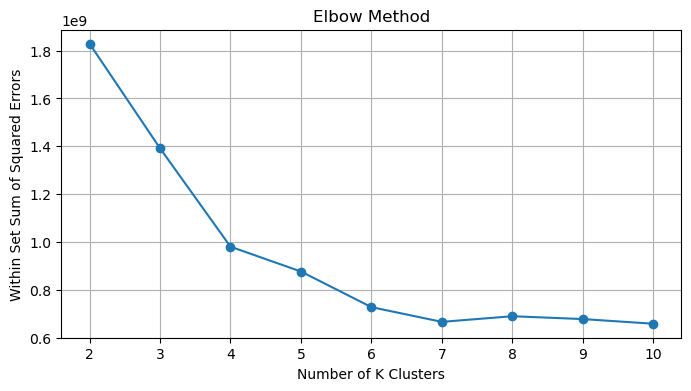

In [48]:
# Calculating elbow method 
wsss_error = []
k_values = list(range(2, 11))
for k in k_values:
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features").setPredictionCol("cluster")
    model = kmeans.fit(kmeans_df)
    wsss_error.append(model.summary.trainingCost)

# Plot the Elbow Method
plt.figure(figsize=(8, 4))
plt.plot(k_values, wsss_error, marker='o')
plt.xlabel('Number of K Clusters')
plt.ylabel('Within Set Sum of Squared Errors')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

#### We can see a slight plateau in error at k = 4, and again at k = 7

Exception ignored in: <function JavaWrapper.__del__ at 0x1555244a5940>
Traceback (most recent call last):
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 53, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
                                              ^^^^^^^^^^^^^^
AttributeError: 'VectorAssembler' object has no attribute '_java_obj'
Exception ignored in: <function JavaWrapper.__del__ at 0x1555244a5940>
Traceback (most recent call last):
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 53, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
                                              ^^^^^^^^^^^^^^
AttributeError: 'VectorAssembler' object has no attribute '_java_obj'


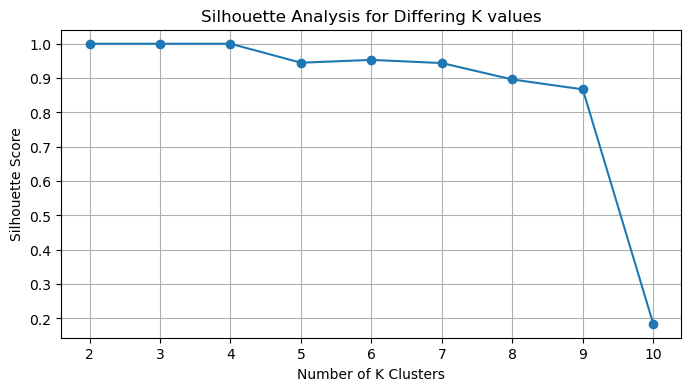

In [49]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Silhouette Analysis
silhouette_scores = []
k_values = list(range(2, 11))

for k in k_values:
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features").setPredictionCol("cluster")
    model = kmeans.fit(kmeans_df)
    predictions = model.transform(kmeans_df)
    evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="cluster", metricName="silhouette")
    silhouette_score = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette_score)

# Plot the Silhouette Scores
plt.figure(figsize=(8, 4))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of K Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Differing K values')
plt.grid(True)
plt.show()

### With a silhouette score of 1, k = 4 seems like a good option for k

In [50]:
# fitting the kmeans model for 7 clusters
kmeans = KMeans().setK(4).setSeed(1).setFeaturesCol("features").setPredictionCol("cluster")
model = kmeans.fit(kmeans_df)

predictions = model.transform(kmeans_df)

In [58]:
# evaluating model using Within Set Sum of Squared Errors
# calculates the sum of the squared euclidian distance of each point in a cluster to it's centroid
within_setsum_ofsqured_errors = model.summary.trainingCost
print(f"Within Set Sum of Squared Errors (WSSSE) = {within_setsum_ofsqured_errors}")
predictions.select("location_id", "location", "city", "state", "cluster")

Within Set Sum of Squared Errors (WSSSE) = 980149463.5356715


DataFrame[location_id: bigint, location: string, city: string, state: string, cluster: int]

In [61]:
cluster0 = predictions.filter(predictions.cluster == 0)
cluster0.select("location_id", "location", "city", "state", "cluster").show(truncate=False)
print("cluster 0 has:", cluster0.count())

+-----------+---------------------+---------------+------------+-------+
|location_id|location             |city           |state       |cluster|
+-----------+---------------------+---------------+------------+-------+
|186        |Houston Aldine C8-186|Aldine         |Texas       |0      |
|239        |Alamo Lake-239       |Salome         |Arizona     |0      |
|259        |Troost-259           |Kansas City    |Missouri    |0      |
|274        |Reading Airport-274  |River View Park|Pennsylvania|0      |
|288        |Hawthorne-288        |South Salt Lake|Utah        |0      |
|288        |Hawthorne-288        |South Salt Lake|Utah        |0      |
|293        |Garden-293           |Anchorage      |Alaska      |0      |
|331        |Lindon-331           |Lindon         |Utah        |0      |
|342        |Lancaster-342        |Lancaster      |Pennsylvania|0      |
|344        |Sunrise Acres-344    |Las Vegas      |Nevada      |0      |
|344        |Sunrise Acres-344    |Las Vegas      |

In [62]:
cluster1 = predictions.filter(predictions.cluster == 1)
cluster1.select("location_id", "location", "city", "state", "cluster").show(truncate=False)
print("cluster 1 has:", cluster1.count())

+-----------+----------------------------------------------------------------+--------------------+-------------+-------+
|location_id|location                                                        |city                |state        |cluster|
+-----------+----------------------------------------------------------------+--------------------+-------------+-------+
|358397     |Kettle Falls District office-368999                             |Kettle Falls        |Washington   |1      |
|226357     |Murray Jordan River Parkway Trail powered by UTOPIA Fiber-238653|West Jordan         |Utah         |1      |
|232584     |200 Eugene Street-244880                                        |Hood River          |Oregon       |1      |
|277304     |Heritage-288343                                                 |Louisville          |Colorado     |1      |
|234444     |Coeur Rochester Admin Building-246740                           |Lovelock            |Nevada       |1      |
|671426     |TFE - Eschi

In [63]:
cluster2 = predictions.filter(predictions.cluster == 2)
cluster2.select("location_id", "location", "city", "state", "cluster").show(truncate=False)
print("cluster 2 has:", cluster2.count())

+-----------+-----------------+---------+------+-------+
|location_id|location         |city     |state |cluster|
+-----------+-----------------+---------+------+-------+
|7820       |Detroit Lake-7820|Mill City|Oregon|2      |
+-----------+-----------------+---------+------+-------+

cluster 2 has: 1


In [64]:
cluster3 = predictions.filter(predictions.cluster == 3)
cluster3.select("location_id", "location", "city", "state", "cluster").show(truncate=False)
print("cluster 3 has:", cluster3.count())

+-----------+---------------------------------------+---------------+----------+-------+
|location_id|location                               |city           |state     |cluster|
+-----------+---------------------------------------+---------------+----------+-------+
|6912       |Indio-29 Palms-6912                    |Indio          |California|3      |
|352092     |5014 - Loyola Village Elementary-362697|Marina del Rey |California|3      |
|352049     |5986 - Palms El-362651                 |Culver City    |California|3      |
|352092     |5014 - Loyola Village Elementary-362697|Marina del Rey |California|3      |
|352049     |5986 - Palms El-362651                 |Culver City    |California|3      |
|65923      |Gibbs Elementary-60921                 |Oronoco        |Minnesota |3      |
|1533718    |2527 - Broad Ave El-1503754            |Carson         |California|3      |
|230347     |Top of Ohlone Street-242643            |Portola Valley |California|3      |
|352092     |5014 - L

In [65]:
print("cluster 0 has:", cluster0.count())
print("cluster 1 has:", cluster1.count())
print("cluster 2 has:", cluster2.count())
print("cluster 3 has:", cluster3.count())

cluster 0 has: 1934099
cluster 1 has: 84
cluster 2 has: 1
cluster 3 has: 72


### Can plot results in 2D using PCA 

## Model - Decision Trees

Predicting the AQI score based on other features: location (lat/lon), weather, but not including pm25. Seeing which features are most important for prediciting AQI.

In [ ]:
dt_df = df.drop('relativehumidity', '

## Model - Linear Regression

#### Looking at Average PM2.5 values

In [ ]:
# create a dataframe of average pm25 by date. this is averaged over all locations
df_pm25 = df.groupBy('date').agg(F.avg('pm25').alias('pm25'))
_pm25 = df_pm25.toPandas()

In [ ]:
# convert to datetime
_pm25['date'] = pd.to_datetime(_pm25['date'])

# sort by date
_pm25 = _pm25.sort_values('date')


plt.figure(figsize=(10, 6))
plt.plot(_pm25['date'], _pm25['pm25'], marker='o', linestyle='-')

plt.title('PM2.5 Values in US')
plt.xlabel('Date')
plt.ylabel('Average PM2.5 (µg/m³)')
plt.grid(True)

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### Split data into  training and tests sets, create model

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

df_model = df

# feature engineering: extract date parts
df_model = df_model.withColumn("year", F.year("date"))
df_model = df_model.withColumn("month", F.month("date"))
df_model = df_model.withColumn("day", F.dayofmonth("date"))
df_model = df_model.withColumn("day_of_week", F.dayofweek("date"))

# creating feature vectors
assembler = VectorAssembler(inputCols=["year", "month", "day", "day_of_week"], outputCol="features")
df_model = assembler.transform(df_model)

# split into test and training sets based on 80/20
train_df, test_df = df_model.randomSplit([0.8, 0.2])

# split into test and training sets based on date
# train_df = df_model.filter(F.col('date') < '2023-01-01')
# test_df = df_model.filter(F.col('date') >= '2023-01-01')

# create a linear regression model
lr_model = LinearRegression(featuresCol='features', labelCol='pm25').fit(train_df)

# print the coefficients and intercept for linear regression
print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")

#### Evaluate the model

In [ ]:
df_model = df

# converting date column to timestamp 
df_model = df.withColumn('timestamp', F.unix_timestamp(F.col('date'), 'yyyy-MM-dd'))

# creating feature vectors
assembler = VectorAssembler(inputCols=["timestamp"], outputCol="features")
df_model = assembler.transform(df_model)

# split into test and training sets based on date
train_df = df_model.filter(F.col('date') < '2023-01-01')
test_df = df_model.filter(F.col('date') >= '2023-01-01')

# create a linear regression model
lr_model = LinearRegression(featuresCol='features', labelCol='pm25').fit(train_df)

# print the coefficients and intercept for linear regression
print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")

In [ ]:
# predictions on training data
train_predictions = lr_model.transform(train_df)

# predictions on testing data
test_predictions = lr_model.transform(test_df)

evaluator = RegressionEvaluator(labelCol="pm25", predictionCol="prediction", metricName="rmse")

# RMSE for training
train_rmse = evaluator.evaluate(train_predictions)

# RMSE for testing
test_rmse = evaluator.evaluate(test_predictions)

print("Training RMSE:", train_rmse)
print("Testing RMSE:", test_rmse)

## Model fitting

Our model fits in the underfitting side of the fitting graph. Our linear regression model is on the more simple side, with only one parameter reading vs. timestamp as the input of trying to predict future values. We started off with pm values across many stations, but averaged these across the entire US and across each day as an input to our model, which simplified the model. Unforunately, the values in our dataset only go a couple of years back. Because it is more simple due to these reasons, the model is prone to underfitting and not being as robust as if we had added more time points.


## Next Models

The next models we are thinking of will utilize more of the parameters we have in our dataset. We can apply k-means clustering to obtain clusters of places with similar levels/patterns of pollution based on features. This would be interesting to investigate as we could look into areas of best and worst pollution in the US. We could also run PCA on these parameter features for dimensionality reduction on our dataset as we have many parameters of data to pool from.

## Conclusions